In [4]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model


import visualkeras
from PIL import ImageFont

import shap

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


import os
import random
import tensorflow as tf
import numpy as np
import shap
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [32]:
top5_acc = TopKCategoricalAccuracy(k=5, name='top5_acc')
top10_acc = TopKCategoricalAccuracy(k=10, name='top10_acc')

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

root_path = r"C:\Users\Jarushen\Desktop\Masters Thesis\Images\Fynbos_Dataset_B"  # Your dataset path

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Adjust for ResNet50
    rotation_range=10,  # Reduced rotation
    width_shift_range=0.1,  # Reduced shift range
    height_shift_range=0.1,  # Reduced shift range
    shear_range=0.1,  # Reduced shear range
    zoom_range=0.1,  # Reduced zoom range
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


# Load images from directory
train_generator = datagen.flow_from_directory(
    root_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    root_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 706 images belonging to 23 classes.
Found 163 images belonging to 23 classes.


In [6]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dropout

# Load the base model, pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
# Assuming base_model is your pre-trained ResNet50 model
for layer in base_model.layers[-30:]:  # Unfreeze the last 30 layers
    layer.trainable = True





x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)  # Adjusted number of neurons
x = Dropout(0.3)(x)  # Adjusted dropout rate
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
# Assuming the rest of the model setup code remains the same




# Rest of the model preparation code remains the same


# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Compile the model with a reduced initial learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_k_categorical_accuracy', top5_acc, top10_acc]
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, verbose=1)

# Train the model with callbacks
history = model.fit(
    train_generator,
    epochs=10,  # Adjust as needed
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)



The `lr` argument is deprecated, use `learning_rate` instead.


Epoch 1/10
23/23 [==============================] - 608s 24s/step - loss: 2.8293 - accuracy: 0.1941 - top_k_categorical_accuracy: 0.4986 - top5_acc: 0.4986 - top10_acc: 0.6969 - val_loss: 2.5437 - val_accuracy: 0.2515 - val_top_k_categorical_accuracy: 0.6074 - val_top5_acc: 0.6074 - val_top10_acc: 0.8037 - lr: 1.0000e-04
Epoch 2/10
23/23 [==============================] - 495s 22s/step - loss: 1.5222 - accuracy: 0.5453 - top_k_categorical_accuracy: 0.8725 - top5_acc: 0.8725 - top10_acc: 0.9490 - val_loss: 1.9376 - val_accuracy: 0.4969 - val_top_k_categorical_accuracy: 0.7485 - val_top5_acc: 0.7485 - val_top10_acc: 0.8773 - lr: 1.0000e-04
Epoch 3/10
23/23 [==============================] - 464s 21s/step - loss: 0.8896 - accuracy: 0.7861 - top_k_categorical_accuracy: 0.9589 - top5_acc: 0.9589 - top10_acc: 0.9858 - val_loss: 1.8370 - val_accuracy: 0.5031 - val_top_k_categorical_accuracy: 0.8344 - val_top5_acc: 0.8344 - val_top10_acc: 0.9080 - lr: 1.0000e-04
Epoch 4/10
23/23 [=============

In [4]:
# Evaluate the model
val_loss, val_accuracy, val_top_5_accuracy, val_top_10_accuracy = model.evaluate(validation_generator)
print(f"Validation accuracy: {val_accuracy * 100:.2f}%")
print(f"Top-5 accuracy: {val_top_5_accuracy * 100:.2f}%")
print(f"Top-10 accuracy: {val_top_10_accuracy * 100:.2f}%")


6/6 [==============================] - 93s 16s/step - loss: 1.1329 - acc: 0.6810 - top_k_categorical_accuracy: 0.8773


ValueError: not enough values to unpack (expected 4, got 3)

In [18]:
model.save(r"C:\Users\Jarushen\Desktop\Masters Thesis\Code\Models\Transfer_B")

INFO:tensorflow:Assets written to: C:\Users\Jarushen\Desktop\Masters Thesis\Code\Models\Transfer_B\assets


INFO:tensorflow:Assets written to: C:\Users\Jarushen\Desktop\Masters Thesis\Code\Models\Transfer_B\assets


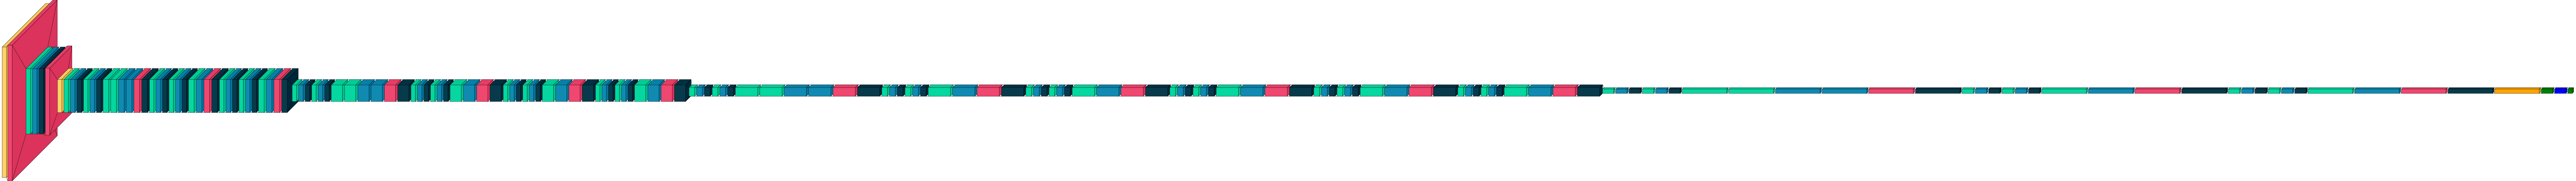

In [16]:
import visualkeras
from collections import defaultdict

# Creating a color palette
color_map = defaultdict(dict)
color_map[GlobalAveragePooling2D]['fill'] = 'orange'
color_map[Dense]['fill'] = 'green'
color_map[Dropout]['fill'] = 'blue'
color_map[ResNet50]['fill'] = 'gray'


visualkeras.layered_view(model,color_map=color_map, type_ignore=[base_model])



In [19]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import plot_model

model = ResNet50(weights='imagenet')
plot_model(model, to_file='resnet50.png', show_shapes=True, show_layer_names=True)


102967424/102967424 [==============================] - 12s 0us/step
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [7]:
import visualkeras
from collections import defaultdict

# Creating a color palette
color_map = defaultdict(dict)
color_map[GlobalAveragePooling2D]['fill'] = 'orange'
color_map[Dense]['fill'] = 'green'
color_map[Dropout]['fill'] = 'blue'
color_map[ResNet50]['fill'] = 'gray'
# Assuming 'model' is your Sequential model

# Specify the font size and style for labels (optional, depends on your system's availability of fonts)
# For Windows, you might need to provide the full path to a .ttf file
# font = ImageFont.truetype("arial.ttf", 12)

# Create a layered view with labels
# If font is not set, the default PIL font will be used

layered_view = visualkeras.layered_view(model, to_file='model_visualization_Transfer.png', color_map=color_map, spacing=10, scale=0.5)

# Save the visualization
layered_view.save('model_visualization_Transfer.png')


TypeError: layered_view() got an unexpected keyword argument 'scale'

## Classification report

In [9]:
validation_generator.reset()
Y_pred = model.predict(validation_generator)


6/6 [==============================] - 91s 14s/step


In [10]:
y_pred = np.argmax(Y_pred, axis=1)

In [11]:
from sklearn.metrics import classification_report

# Generate target_names based on the classes present in the validation generator
target_names = [k for k, v in sorted(validation_generator.class_indices.items(), key=lambda item: item[1])]

# Generate the classification report
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_names, labels=np.arange(len(target_names))))

Classification Report
                         precision    recall  f1-score   support

       Aloe arborescens       1.00      0.83      0.91         6
       Aristea capitata       1.00      0.75      0.86         4
 Baloskion tetraphyllum       1.00      1.00      1.00         4
     Carpobrotus edulis       0.57      1.00      0.73         4
   Cotyledon orbiculata       0.00      0.00      0.00         9
       Curio talinoides       1.00      1.00      1.00         8
      Erica arborescens       0.50      1.00      0.67         5
          Erica cinerea       0.50      0.14      0.22         7
         Erica discolor       0.46      1.00      0.63         6
  Helichrysum petiolare       0.89      0.73      0.80        11
 Leucadendron argenteum       0.50      0.20      0.29        10
 Leucadendron laureolum       1.00      0.14      0.25         7
  Leucadendron salignum       0.78      1.00      0.88         7
       Melianthus major       0.91      1.00      0.95        10
  

## Confusion Matrix

In [13]:
cm = confusion_matrix(validation_generator.classes, y_pred)

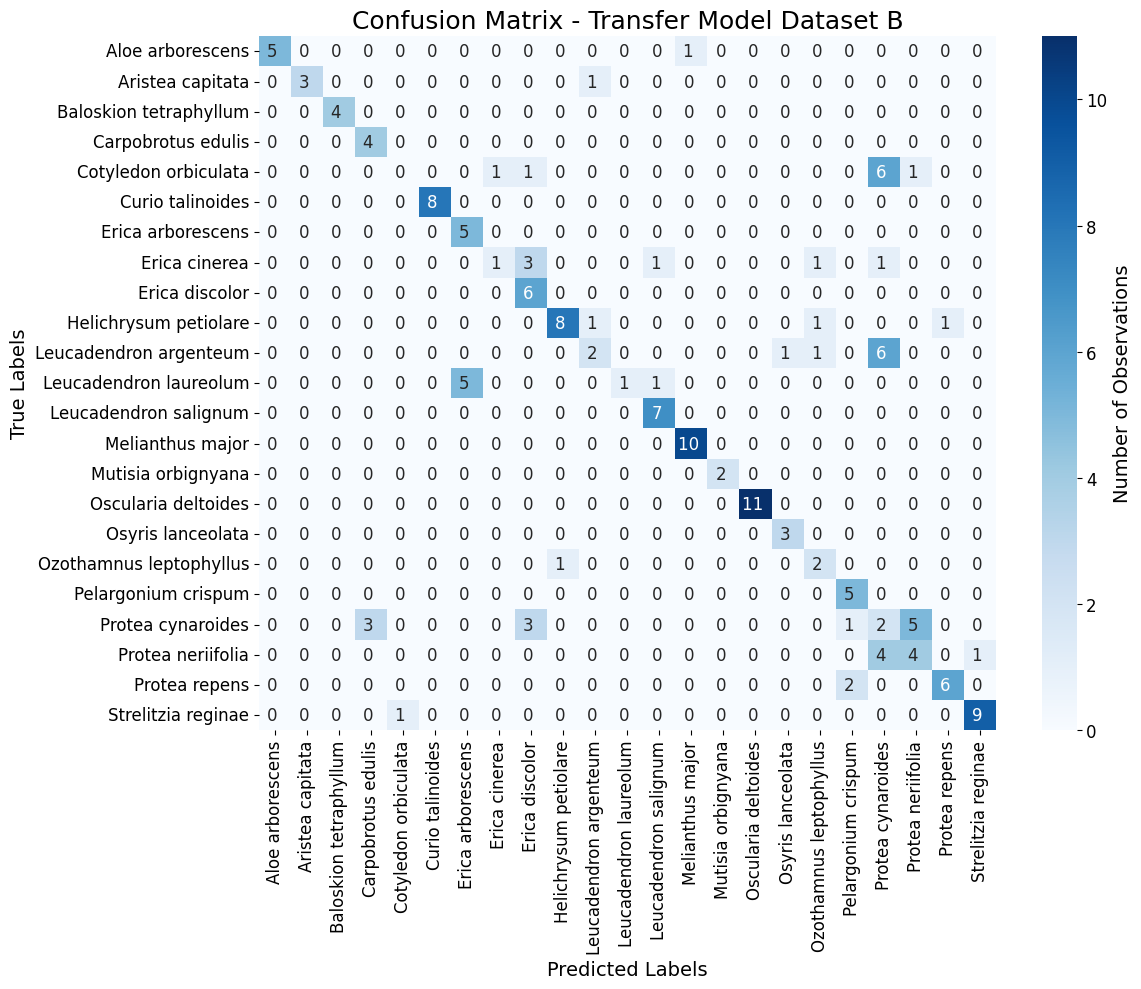

In [41]:
plt.figure(figsize=(12, 10))  # Increased figure size for better readability

# Creating the heatmap
ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
                 xticklabels=target_names, yticklabels=target_names)

# Rotate the x-axis labels
plt.xticks(rotation=90)  # Rotate x-axis labels to be vertical
plt.yticks(rotation=0)  # Ensure y-axis labels are horizontal for consistency

# Setting labels and title with increased font size for readability
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix - Transfer Model Dataset B', fontsize=18)

# Increasing the font size of the annotations
for t in ax.texts:
    t.set_text(t.get_text() + " ")  # Adding space for better visibility
    t.set_size(12)  # Increase the annotation text size if needed

ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust tick label size

# Adjust color bar label size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)  # Adjust the color bar tick label size
cbar.set_label('Number of Observations', fontsize=14)

plt.tight_layout()  # Adjusts the plot to fit into the figure area.

# Save the figure with a higher resolution
plt.savefig(r"C:\Users\Jarushen\Desktop\Masters Thesis\Report_Final\images\Results\confusion_matrix_Transfer_B.png",
            format='png', dpi=400, bbox_inches='tight')  # Increased DPI for higher resolution

# Show the plot
plt.show()

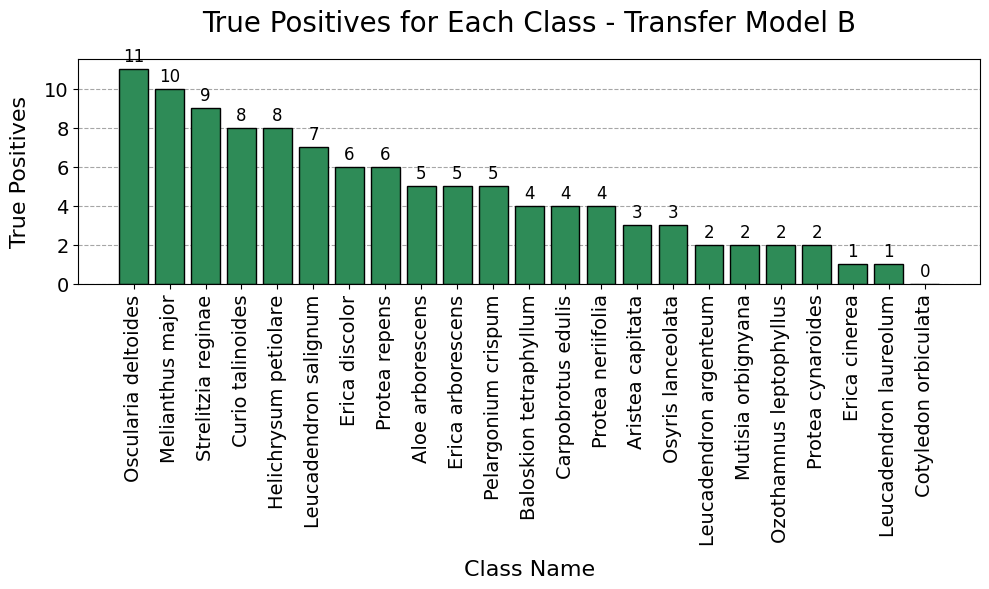

In [40]:
import matplotlib.pyplot as plt
import numpy as np



# Extract true positives from the confusion matrix
true_positives = np.diag(cm)

# Pair each class name with its corresponding true positive count and sort
sorted_pairs = sorted(zip(target_names, true_positives), key=lambda x: x[1], reverse=True)

# Unzip the sorted pairs
sorted_target_names, sorted_true_positives = zip(*sorted_pairs)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size

# Create bar plot with sorted data
bars = ax.bar(sorted_target_names, sorted_true_positives, color='seagreen', edgecolor='black')

# Add labels and title
ax.set_xlabel('Class Name', fontsize=16, labelpad=10)
ax.set_ylabel('True Positives', fontsize=16, labelpad=10)
ax.set_title('True Positives for Each Class - Transfer Model B', fontsize=20, pad=20)

plt.xticks(rotation=90, fontsize=14)  # Labels are now horizontal
plt.yticks(fontsize=14)

# Add data labels
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=12)

# Add grid lines behind the bars for better readability of the y-values
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.7)

# Tight layout to ensure everything fits without overlapping
plt.tight_layout()

plt.savefig(r"C:\Users\Jarushen\Desktop\Masters Thesis\Report_Final\images\Results\Transfer_B_true_positives_bar_graph.png", format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

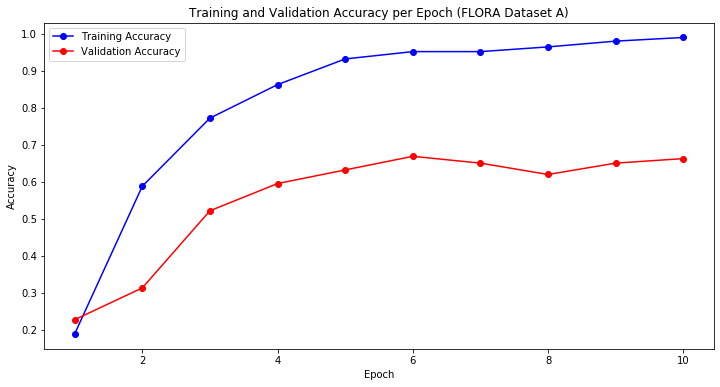

In [8]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by the model.fit() method

# Extract the number of epochs
epochs = range(1, len(history.history['acc']) + 1)

# Extracting training and validation accuracy
training_accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']

# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, training_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch (FLORA Dataset B)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Accuracy

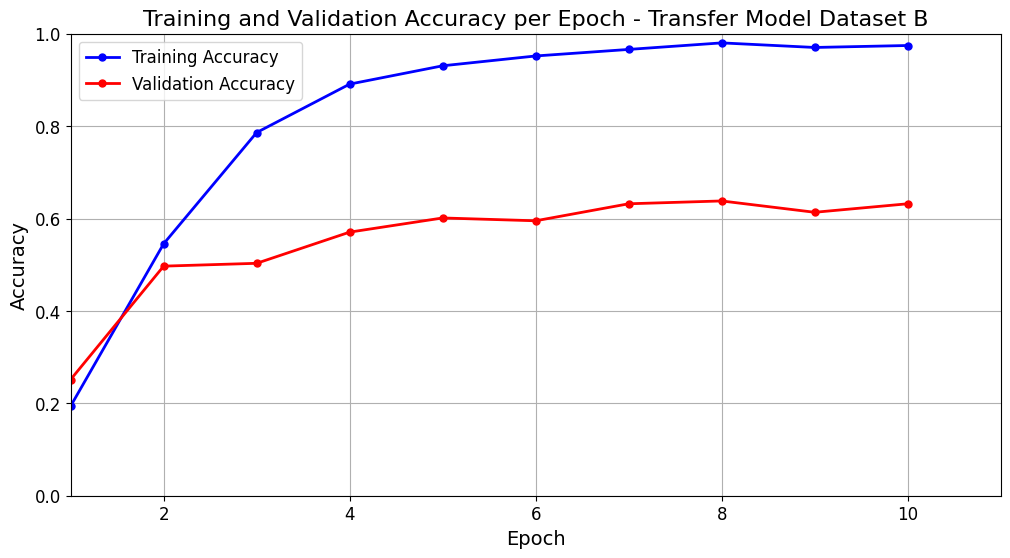

In [15]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by the model.fit() method
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12, 6))

# Increase line thickness and marker size
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy', linewidth=2, markersize=5)
plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy', linewidth=2, markersize=5)

# Title and labels with increased font size
plt.title('Training and Validation Accuracy per Epoch - Transfer Model Dataset B', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

# Set fixed axes limits
plt.ylim([0, 1])
plt.xlim([1, 11])

# Enhanced tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines
plt.grid(True)

# Increase legend font size
plt.legend(fontsize=12)

# Save the figure in high resolution
plt.savefig(r"C:\Users\Jarushen\Desktop\Masters Thesis\Report_Final\images\Results\Transfer_Acc_B.png", format='png', dpi=300)

plt.show()



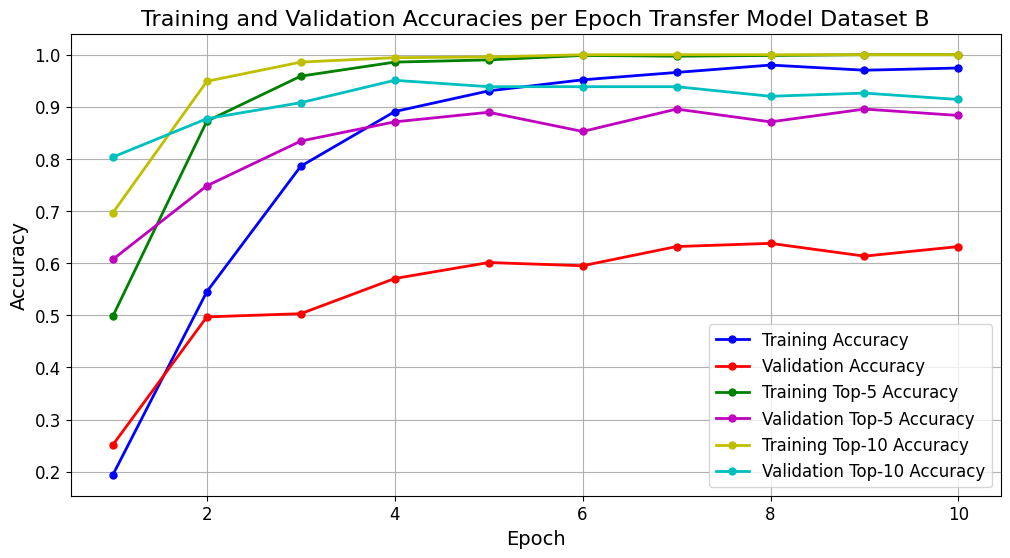

In [16]:
import matplotlib.pyplot as plt

# Assuming 'history' contains 'accuracy', 'val_accuracy', 'top5_accuracy', 'val_top5_accuracy', 'top10_accuracy', 'val_top10_accuracy'
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12, 6))

# Standard accuracy with increased line thickness and marker size
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy', linewidth=2, markersize=5)
plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy', linewidth=2, markersize=5)

# Top-5 accuracy with increased line thickness and marker size
plt.plot(epochs, history.history['top5_acc'], 'go-', label='Training Top-5 Accuracy', linewidth=2, markersize=5)
plt.plot(epochs, history.history['val_top5_acc'], 'mo-', label='Validation Top-5 Accuracy', linewidth=2, markersize=5)

# Top-10 accuracy with increased line thickness and marker size
plt.plot(epochs, history.history['top10_acc'], 'yo-', label='Training Top-10 Accuracy', linewidth=2, markersize=5)
plt.plot(epochs, history.history['val_top10_acc'], 'co-', label='Validation Top-10 Accuracy', linewidth=2, markersize=5)

# Title and labels with increased font size
plt.title('Training and Validation Accuracies per Epoch Transfer Model Dataset B', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

# Enhanced tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines
plt.grid(True)

# Increase legend font size
plt.legend(fontsize=12)

# Save the figure in high resolution
plt.savefig(r"C:\Users\Jarushen\Desktop\Masters Thesis\Report_Final\images\Results\t5t10_B_Transfer.png", format='png', dpi=300)

# Show the plot
plt.show()


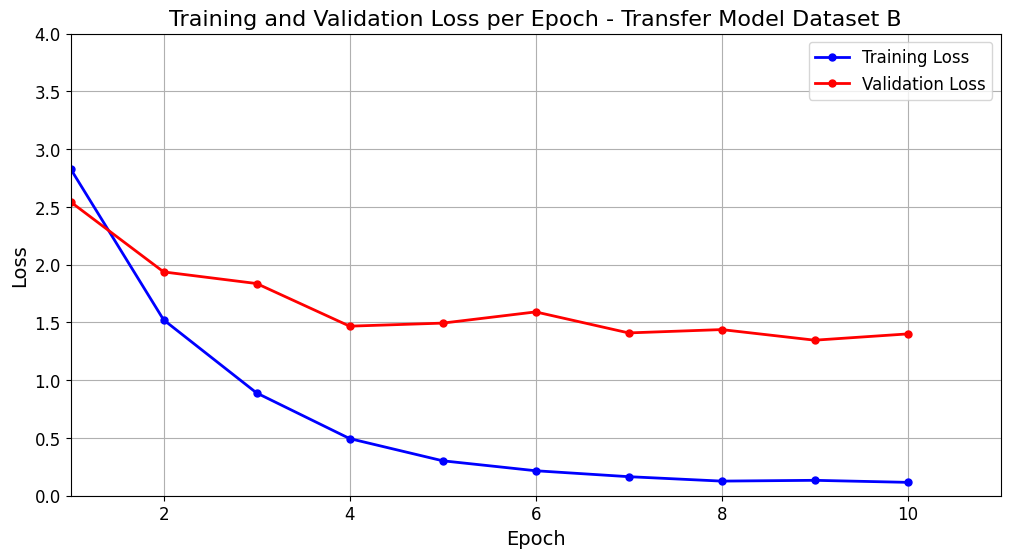

In [17]:
import matplotlib.pyplot as plt

# Replace 'loss' and 'val_loss' with the actual keys if they are different
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(12, 6))

# Plot training and validation loss with increased line thickness and marker size
plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss', linewidth=2, markersize=5)
plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss', linewidth=2, markersize=5)

# Title and labels with increased font size
plt.title('Training and Validation Loss per Epoch - Transfer Model Dataset B', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Enhanced tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines
plt.grid(True)

# Increase legend font size
plt.legend(fontsize=12)

# Set fixed axes limits
plt.ylim([0, 4])
plt.xlim([1, 11])

# Save the plot in high resolution
plt.savefig(r"C:\Users\Jarushen\Desktop\Masters Thesis\Report_Final\images\Results\Transfer_epoch_B_Loss.png", format='png', dpi=300)

# Show the plot
plt.show()

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shap
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Function to load and preprocess the image
def load_preprocess_image(img_path, target_size):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale the image
    return img_array


# Directory of the class you want to analyze
class_dir = r"C:\Users\Jarushen\Desktop\Masters Thesis\Images\Fynbos_Dataset_B\Leucadendron salignum"  # Replace with your class directory

# Directory to save the SHAP plots
save_dir = r"C:\Users\Jarushen\Desktop\Masters Thesis\Report_Final\images\Results\Transfer_B_SHAP"  # Replace with your desired save directory
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Initialize SHAP DeepExplainer
explainer = shap.DeepExplainer(model, np.zeros((1, 150, 150, 3)))

# Iterate through each image in the specified class directory
for img_file in os.listdir(class_dir):
    if 'IMG' in img_file:
        img_path = os.path.join(class_dir, img_file)
        preprocessed_image = load_preprocess_image(img_path, (150, 150))

        # Predict the class of the image
        predictions = model.predict(preprocessed_image)
        predicted_class = np.argmax(predictions, axis=1)[0]

        # Compute SHAP values for the predicted class
        shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough 
        shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.passthrough
        
        shap_values = explainer.shap_values(preprocessed_image)
        shap_values_for_predicted_class = shap_values[predicted_class][0]

        # Plot SHAP values
        plt.figure()
        shap.image_plot(shap_values_for_predicted_class, preprocessed_image[0],show=False)

        # Save the plot in the specified directory
        plt.savefig(os.path.join(save_dir, f'shap_output_{img_file}_leucadendron_salignum.png'))
        plt.close()  # Close the plot to free memory

print("All SHAP analysis plots saved.")



1/1 [==============================] - 0s 204ms/step
All SHAP analysis plots saved.


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Species with low F1-scores such as Erica cinerea and Protea cynaroides in both datasets to understand feature contributions that lead to poor model performance. Species with high precision but low recall or vice versa, such as Leucadendron laureolum in Dataset B, to identify features that are causing imbalanced predictions. Species with high F1-scores such as Curio talinoides and Oscularia deltoides in Dataset B to understand which features contribute positively to the model's predictions and potentially apply these insights to improve predictions for other species.

In [37]:
from sklearn.metrics import f1_score

# Evaluate the model on the validation set
val_loss, val_accuracy, top_k_categorical_accuracy, val_top5_acc, val_top10_acc = model.evaluate(validation_generator)

# Get predictions and true labels from the validation set
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

# Calculate F1 score for the validation set
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Prepare the data for the table
data = {
    "Metric": ["Accuracy", "F1 Score", "Loss", "Top 5 Accuracy", "Top 10 Accuracy"],
    "Value": [val_accuracy, f1, val_loss, val_top5_acc, val_top10_acc]
}

# Create DataFrame and display
results_table = pd.DataFrame(data)
print(results_table)

6/6 [==============================] - 88s 15s/step
            Metric     Value
0         Accuracy  0.650307
1         F1 Score  0.611181
2             Loss  1.308513
3   Top 5 Accuracy  0.883436
4  Top 10 Accuracy  0.938650


6/6 [==============================] - 94s 16s/step - loss: 1.3127 - accuracy: 0.6687 - top_k_categorical_accuracy: 0.8896 - top5_acc: 0.8896 - top10_acc: 0.9264


AxisError: axis 1 is out of bounds for array of dimension 1